# Redes Neurais Multilayer Perceptron (MLP) com PyTorch

Redes Neurais podem apresentar um número massivo de parâmetros com dezenas de camadas a serem aprendidas (nesse caso, chamamos de ''deep learning''). Para ajudar a construir essas redes, o PyTorch possui o módulo `nn`, que contêm diversas ferramentas para construir redes neurais de forma eficiente.

In [1]:
# Importando os pacotes necessários

# comandos para plotar imagens mais bem definidas no notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

# Algumas funções auxiliares
import helper

import matplotlib.pyplot as plt

Como exemplo, vamos mais uma vez utilizar o já conhecido dataset MNIST, formado por imagens de digitos em tons de cinza de dimensão 28x28, apresentados na imagem abaixo.



<img src='assets/mnist.png'>

Mais uma vez, vamos usar o pacote `torchvision` para carregar o dataset.

In [2]:
from torchvision import datasets, transforms

# Define a transformação dos dados. 
# Note que nesse caso joga um valor médio de 0.5 e desvio de 0.5, normalizando os valores entre -1 e 1.
# (https://discuss.pytorch.org/t/understanding-transform-normalize/21730)
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Criamos o data loader de treinamento `trainloader` e criamos um _iterator_ `iter(trainloader)`, que será chamadado da seguinte forma:

```python
for image, label in trainloader:
    ## do things with images and labels
```

Note que usamos batches de tamanho 64. Aqui vamos consultar o primeiro batch para verificar os dados. Observe que `images` aqui é um vetor com tamanho `(64, 1, 28, 28)`, ou seja, 64 imagens por batch, $1$ cor por canal (se fossem imagens coloridas seriam 3 canais), e imagens de 28x28 pixels.

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


plotando uma das imagens

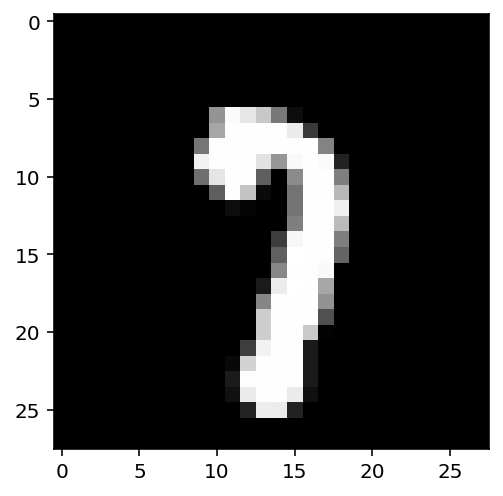

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Inicialmente, podemos construir uma rede usando matrizes e multiplicação de matrizes. Depois, vamos refazer nossa rede usando as ferramentas do modulo `nn`. 

As camadas da rede MLP são chamadas de *fully-connected* ou *dense*, isso porque  todas as unidades de uma camada está conectada a todas as unidades da camada seguinte. As entradas de cada uma das camadas deve ser um vetor de uma única dimensão, e por isso nossas imagens de 28x28 devem ser convertidas em tensores de 784 unidades. Sendo assim, nosso tensor de tamanho `(64, 1, 28, 28)` é convertido para um de tamanho `(64, 784)`. Esse procedimento é chamado de *flattening*, nós achatamos um tensor de 2 dimensões em um tensor de 1 dimensão.

In [5]:
## Definindo a função de ativação
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

# fazendo o flattening. Mantém o tamanho da primeira dimensão (64), referente ao tamanho do batch
#    e transforma todas as outras dimensões em uma única dimensão.
inputs =  images.view(images.shape[0],-1)

# pesos conectando a camada de entrada (784) à camada escondida 
#    note que a camada escondida é composta por 256 neurônios
W1 = torch.randn(inputs.shape[1] , 256)
# pesos conectando a camada escondida à camada de saída.
#    note que a camada de saída tem 10 neurônios pois queremos classificar 10 dígitos (classes)
W2 = torch.randn(256, 10)

# termos de bias para a camada escondida de camada de saída
B1 = torch.randn(256)
B2 = torch.randn(10)

# computa os termos da camada escondida
h = sigmoid(torch.mm(inputs,W1) + B1) # [64, 784] * [784, 256] -> [64, 256]

# computa a saída da camada de saída, ou seja, a saída da rede
out = torch.mm(h,W2) + B2 # -> [64, 256] * [256, 10] -> [64, 10]

Dadas essas 10 saídas, queremos apresentar uma imagem a rede e computar a probabilidade de pertencer a cada classe, o que, a princípio, será algo do tipo:


<img src='assets/image_distribution.png' width=500px>

A probabilidade para cada classe é mais ou menos a mesma, porque a rede não foi treinada.

Para calcular essa distribuição de probabilidades, frequentemente é usada a função [**softmax**](https://en.wikipedia.org/wiki/Softmax_function), a qual pode ser definida como:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

O que a função faz é "esmagar" a saida da rede para valores entre zero e um e depois normalizar esse valor, sendo assim, a soma das probabilidades de cada classe vai ser igual a 1.

In [6]:
def softmax(x):
    # dim = 1 é para executar a soma pelo eixo 1, percorrendo todas as 10 possíveis classes, 
    #    e não cada uma das amostras. A saída da softmax será um tensor de 64x10, ou seja, para cada
    #    amostra, a probabilidade dela pertencer a cada uma das classes.
    return torch.exp(x)/torch.sum(torch.exp(x),dim = 1).view(-1,1)

# Aqui, probabilities recebe a saída da softmax, ou seja, o tensor com formato (64,10) 
probabilities = softmax(out)

# verificando o formato (64, 10)
print(probabilities.shape)
# Verificando se a soma do valor das probabilidades de cada amostra é igual a 1.
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Construíndo nossa rede usando PyTorch

Agora vamos ver como fica a construção da nossa rede usando o modulo `nn` do PyTorch.

In [7]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Entradas para transformação linear da camada escondida
        self.hidden = nn.Linear(784, 256)
        # Camada de saída, 10 unidades, 1 para cada dígito
        self.output = nn.Linear(256, 10)
        
        # Define a função Sigmoid e Softmax
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Passa o tensor de entrada por cada uma das operações
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Indo por partes

```python
class Network(nn.Module):
```

Aqui herdamos da classe `nn.Module`. Combinada com `super().__init__()` criará uma classe que trilha a arquitetura e fornece varios atributos e métodos. Essa herança é obrigatória e qualquer nome pode ser dado à classe.

```python
self.hidden = nn.Linear(784, 256)
```

Essa linha cria um modulo para a transformação linear , $x\mathbf{W} + b$, com 784 entradas e 256 saídas, e aqui chamada de `self.hidden`, para nossa camada escondida. O módulo cria automaticamente os tensores de pesos e bias, os quais serão usados no método `forward`. Esse pesos e bias podem ser acessados após instanciar a rede (`net`) usando os comandos `net.hidden.weight` e `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

De forma similar, criamos outra transformação linear, com 256 entradas e 10 saídas.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Aqui definimos a função de ativação Sigmoid para ativação, e a Softmax para computar as probabilidades. Setando `dim=1` na `nn.Softmax(dim=1)` estamos computando os valores para cada coluna.

```python
def forward(self, x):
```

As redes criadas usando o módulo `nn.Module` do PyTorch devem definir o método `forward`. Ela recebe como entrada um tensor `x` e passa ele pelas operações definidas no método `__init__`.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Aqui o tensor de entrada `x` é passado por cada uma das operações e o retorno é jogado de volta pra `x`. O vetor passa pela camada escondida, pela Sigmoid, pela camada de saída, e finalmente pela Softmax. A sequência em que esses métodos são definidos no método `__init__` não importa, mas eles devem ser definidos na ordem correta no método `forward`

Agora podemos criar nosso objeto `Network`.

In [8]:
# Criando a rede e visualizando sua representação em forma de texto.
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

A mesma rede pode ser definida de modo mais conciso e limpo usando o módulo `torch.nn.functional`. Para isso, importamos o módulo `F`, `import torch.nn.functional as F`.

In [9]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Entradas para transformação linear da camada escondida
        self.hidden = nn.Linear(784, 256)
        # Camada de saída, 10 unidades, 1 para cada dígito
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Camada escondida com ativação Sigmoid
        x = F.sigmoid(self.hidden(x))
        # Camada escondida com ativação Softmax 
        x = F.softmax(self.output(x), dim=1)
        
        return x

### Funções de ativação

Até agora nós utilizamos a função de ativação Sigmoid, mas no geral, qualquer função pode ser usada como uma função de ativação. O único requisito é que a função seja não linear. Aqui tem alguns exemplos de funções de ativação comuns: Tanh (Tangente hyperbolic), e ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

Na prática, ReLU é a função usada quase que exclusivamente para a ativação  de camadas escondidas.

### Construir uma rede neural

<img src="assets/mlp_mnist.png" width=600px>

> **Exercício:** Crie uma rede neural com 784 neurônios de entrada, uma camada escondida de 128 unidades e função de ativação ReLU, outra camada escondida com 64 neurônios e novamente a função de ativação ReLU, e finalmente uma camada de saída com a Softmax como função de ativação, como mostrado na figura acima. Para usar a ReLU, pode usar o módulo `nn.ReLU` ou a função `F.relu`.

Uma boa prática é nomear suas camadas por seu tipo, como 'fc', por exemplo, representando camadas _fully-connected_. Para varias camadas, use `fc1`, `fc2`, etc.

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Passagem Forward 

Agora que temos nossa rede, vamos ver o que acontece quando apresentamos uma imagem a ela.

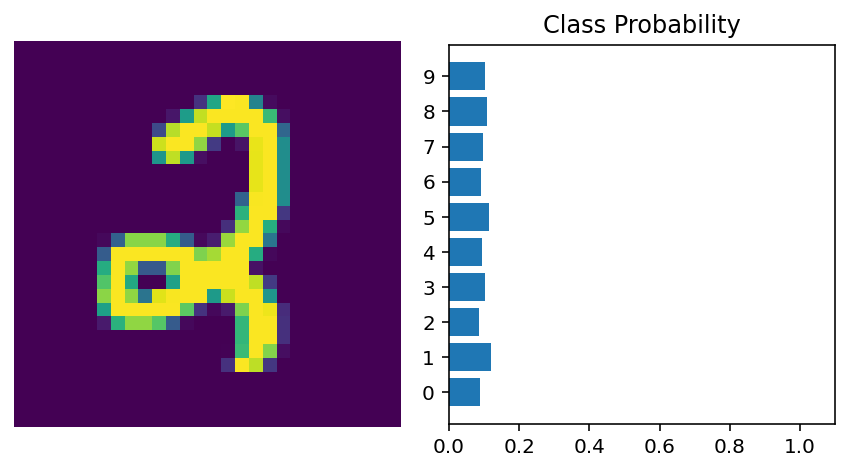

In [11]:
# Obtendo algumas imagens
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Redimensionando essas imagens em vetores de 1 dimensão. 
#    Novo formato deve ser(tamanho do batch, número de canais de cor, pixels da imagem) 
images.resize_(64, 1, 784)
# podemos usar tambem images.resize_(images.shape[0], 1, 784) para pegar o tamanho do batch automaticamente

# Passagem Forward pela rede
img_idx = 2
ps = model(images[img_idx,:])
#ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

Como pudemos ver, nossa rede não faz ideia de que digito seja. Isso porque ela foi inicializada com pesos aleatórios e ainda não foi treinada!


### Usando `nn.Sequential`

PyTorch também fornece um modo mais conveniente para construir redes mais simples, onde o tensor é passado de forma sequencial pelas operações, `nn.Sequential` ([documentação](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Podemos utilizá-lo para construir uma rede similar equivalente à acima:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


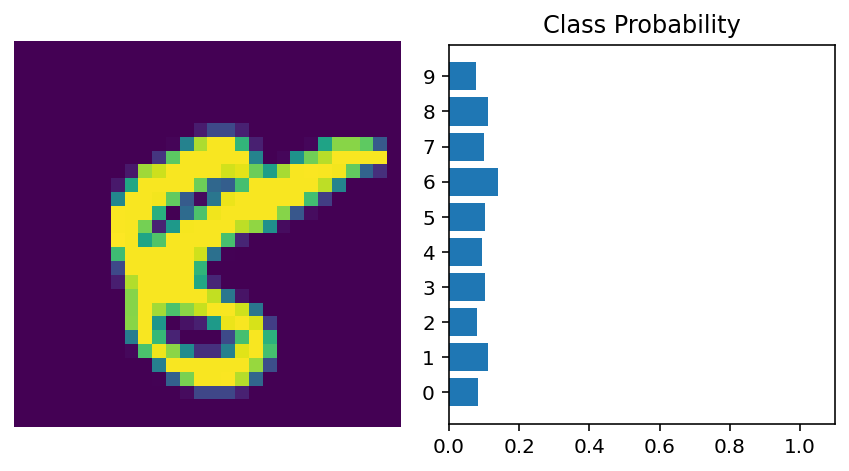

In [12]:
# Hiper-parametros da rede 
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Construindo a rede feed-forward
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Passo Forward de uma única amostra pela rede e mostrando a saída
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Nosso modelo aqui é o mesmo que o de antes, com 784 unidades de entrada, uma camada oculta com 128 unidades, ativação ReLU, camada oculta com 64 unidades seguida por outra ReLU, e então a camada de saída com 10 unidades seguida pela Softmax.

As operações ficam disponíveis se consultadas pelo indice apropriado. Podemos, por exemplo, consultar os pesos da primeira operação linear usando `model[0]`.

In [13]:
print(model[0])
print(model[0].weight)
# print(model[0].bias)

Linear(in_features=784, out_features=128, bias=True)
Parameter containing:
tensor([[-0.0155,  0.0316, -0.0316,  ...,  0.0056, -0.0063, -0.0083],
        [ 0.0238,  0.0181, -0.0071,  ...,  0.0186,  0.0052,  0.0309],
        [ 0.0218, -0.0020,  0.0243,  ...,  0.0070,  0.0123,  0.0058],
        ...,
        [-0.0244, -0.0219,  0.0121,  ..., -0.0024,  0.0142, -0.0294],
        [-0.0052, -0.0280,  0.0299,  ..., -0.0315,  0.0116, -0.0142],
        [-0.0088,  0.0276, -0.0262,  ..., -0.0218,  0.0111, -0.0040]],
       requires_grad=True)


Podemos também passar um `OrderedDict` para dar um nome a cada camada de forma individual, e assim buscar por elas sem precisar passar um índice. Note que as chaves desse dicionário devem ser únicas, então _cada operação deve ter um nome diferente_.

In [14]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Agora podemos acessar as camadas tanto pelo indice quanto pelo nome.

In [15]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


# Treinando a rede Neural

A rede que construimos ainda não é tão esperta, e não é capaz de reconhecer os dígitos:

<img src="assets/function_approx.png" width=500px>

A princípio, a função responsável por mapear as entradas para as saídas é composta por pesos aleatórios. Nós vamos treinar o modelo apresentando dados reais, e ajustando esses pesos a fim de aproximar a saída da função do rótulo real esperado.

Para encontrar esses pesos, ou parametros, precisamos identificar o quanto a rede está errando, e pra isso usamos a já conhecida **funçao loss** (também chamada de função de custo), uma medida de quanto as estimativas da rede estão errando. Uma função loss que já vimos para regressão e classificação é o erro médio quadrático:

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$
onde $n$ é o número de amostras de treinamento, $y_i$ são os rótulos verdadeiros, e $\hat{y}_i$ são os rótulos estimados.

Minimizando esse erro ao ajustar os pesos da rede conseguimos encontrar a configuração em que o erro é mínimo e a rede fica pronta para estimar os rótulos que fornecem a melhor acurácia. Podemos encontrar esse erro mínimo utilizando um processo chamado **gradiente descendente**. O gradiente é o vetor de derivadas, ou seja, inclinação da função de custo em cada ponto, em direção ao mínimo da função. Para alcançar o ponto mínimo, devemos seguir o gradiente na direção de sua descida. Pense se estivesse descendo uma montanha e cada iteração fosse um passo na direção de sua base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

Para redes com uma única camada, o gradiente descendente é mais fácil de implementar, como vimos na última aula. No entanto, fica mais complicado para redes mais profundas, como a que construímos. A complexidade é tanta que levou cerca de 30 anos até que os pesquisadores descobrissem uma forma adequada de treinar essas redes.

O treinamento de redes multi-camadas é feito pelo algoritmo **backpropagation**, o qual é apenas uma aplicação da regra de cadeia em cálculo. É mais fácil entender se convertermos uma rede de 2 camadas em uma representação gráfica.



<img src='assets/backprop_diagram.png' width=550px>

No passo forward, os dados e operações seguem de baixo pra cima. A entrada $x$ passa pela transformação linear
$L_1$ com pesos $W_1$ e bias $b_1$. A saída passa pela Sigmoid $S$ e outra camada linear $L_2$. Finalmente computamos a saída da função loss $\ell$, a qual é usada para medir o quanto a rede está errando. O objetivo é ajustar os pesos e bias para minimizar $\ell$.

Para treinar os pesos com gradiente descendente, propagamos o gradiente do erro de volta pela rede. Cada operação tem alguns gradientes entre a entrada e a saída. Conforme enviamos os gradientes de volta, multiplicamos o gradiente atual pelo gradiente da operação. Matematicamente falando, o que o método faz é apenas calcular o gradiente do erro em relação aos pesos usando a regra da cadeia.


$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

Os pesos são atualizados usando esse gradiente em conjunto com uma taxa de aprendizagem $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

A taxa de aprendizagem $\alpha$ é escolhida de forma que a atualização dos pesos a cada passo seja pequena o suficiente para que o método chegue ao valor mínimo de loss de forma iterativa.

## Funções de loss em PyTorch

Vamos relembrar como calcular funções de loss usando PyTorch. Usando o módulo `nn`, podemos encontrar várias funções _loss_, como por exemplo a entropia cruzada (`nn.CrossEntropyLoss`). Essa função geralmente é atribuída como `criterion`. Como vimos anteriormente, classificação multi-classe, como no caso da MNIST, usamos a softmax para predizer a probabilidade de cada classe. Com a saída da softmax, queremos usar a entropia cruzada como função de _loss_. Para calcular o erro de fato, precisamos definir o critério e passar os rótulos corretos à nossa rede.



Note um ponto muito importante na documentação:[documentação de `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> Esse critério combina `nn.LogSoftmax()` e `nn.NLLLoss()` em uma única classe.
>
> A saída deve ser em um formato específico (logit).

Isso significa que precisamos passar diretamente a saída da rede para computar o _loss_, em vez de fornecer a saída após passar pela função Softmax. Essa saída direta (antes da Softmax) é chamada *logit* ou *scores*. Usamos os logits porque as probabilidades fornecidas pela Softmax ficam muito próximas de 0 ou 1. ([leia mais aqui](https://docs.python.org/3/tutorial/floatingpoint.html)). Ou seja, é melhor evitar calculos usando probabilidades, uma vez que é mais comum usar o log das probabilidades.

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define as transformações para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Baixa e/ou carrega os dados
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [17]:
# Construindo uma rede feed-forward
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Definindo a função loss
criterion = nn.CrossEntropyLoss()

# Obtendo os dados
images, labels = next(iter(trainloader))
# achatando a imagem (2-D para 1-D)
images = images.view(images.shape[0], -1)

# Passagem Forward pass, pegando os logits
logits = model(images)
# Calculando o erro com os logits e os rótulos
loss = criterion(logits, labels)

print(loss)

tensor(2.3226, grad_fn=<NllLossBackward>)


As vezes pode ser mais conveniente construir um modelo usando como saída a função log-softmax usando `nn.LogSoftmax` ou `F.log_softmax` ([documentação](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Então você pode obter as probabilidades reais através da exponencial `torch.exp(output)`. Com a saída da log-softmax, podemos computar o _negative log likelihood_, `nn.NLLLoss` ([documentação](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)), o que é equivalente à saída da `nn.CrossEntropyLoss`. 

>**Exemplo:** Construindo um modelo que retorne o log-softmax como saída e calcule a função de loss utilizando o _negative log likelihood_. Note que para `nn.LogSoftmax` e `F.log_softmax` você precisa setar o parâmetro `dim` de forma apropriada. `dim=0` computa o softmax pelas linhas (amostras), de forma que as colunas somem 1, enquanto `dim=1` calcula a softmax pelas colunas, de forma que as linhas somem 1. Pense no que deseja como saída e escolha `dim` de forma apropriada.


In [18]:
# TODO: Construa sua rede feed-forward com saída log-softmax
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# TODO: Defina a função de loss
criterion = nn.NLLLoss()

# Obtém os dados
images, labels = next(iter(trainloader))
# achatando a imagem (2-D para 1-D)
images = images.view(images.shape[0], -1)

# Passagem Forward pass, pegando os logits
logps = model(images)
# Calculando o erro com os logits e os rótulos
loss = criterion(logps, labels)

print(loss)

tensor(2.3102, grad_fn=<NllLossBackward>)


## Autograd

Agora que sabemos como computar o _loss_, como usá-lo no backpropagation? O PyTorch tem um módulo chamado `autograd` que computa os gradientes de forma automática. Autograd armazena as operações executadas em cada tensor, então faz o passe de volta calculando os gradientes pelo caminho. Para ter certeza que PyTorch está armazenando as operações de um tensor, devemos setar `requires_grad = True` no tensor. Podemos fazer isso em sua criação com a chamada `requires_grad`, ou a qualquer momento com `x.requires_grad_(True)`.

Também é possível desligar os gradiente de um bloco usando `torch.no_grad()`:

```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Além disso, podemos ligar ou desligar a armazenagem de todos os gradientes ao mesmo tempo usando `torch.set_grad_enabled(True|False)`.

Os gradiente são computados em relação a alguma variável `z` com `z.backward()`. Isso faz o passo de volta pela operação que criou `z`.

In [19]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.0616, -1.3427],
        [-0.5776,  0.5455]], requires_grad=True)


In [20]:
y = x**2
print(y)

tensor([[1.1269, 1.8030],
        [0.3337, 0.2976]], grad_fn=<PowBackward0>)


Abaixo podemos ver a operação que criou `y`, uma operação ao quadrado `PowBackward0`.

In [21]:
## grad_fn mostra a função que gerou essa variável
print(y.grad_fn)

O modulo autograd mantém registro dessas operações e sabe como computar o gradiente de cada uma. Dessa forma, ele consegue computar o gradiente para uma cadeia de operações, com relaçao a qualquer tensor. Vamos reduzir o tensor `y` para um escalar, computando a média.

In [22]:
z = y.mean()
print(z)

tensor(0.8903, grad_fn=<MeanBackward0>)


Podemos verificar os gradientes de `x` e `y`, mas no momento eles estão vazios.

In [23]:
print(x.grad)
print(y.grad)

None
None


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  


Para computar os gradientes, precisamos executar o comando `.backward` na variável `z`, por exemplo. isso irá computar o gradiente de `z` em relação a `x`.

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [24]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.5308, -0.6714],
        [-0.2888,  0.2728]])
tensor([[ 0.5308, -0.6714],
        [-0.2888,  0.2728]], grad_fn=<DivBackward0>)


O calculo dos gradientes é muito importante para qualquer rede neural. Uma vez que conhecemos o gradiente, podemos executar o gradiente descendente.

## Juntando a função Loss e Autograd 

Quando criamos uma rede com PyTorch, todos os parametros são inicializados com `requires_grad = True`. Isso significa que quando computamos o erro e chamamos `loss.backward()`, os gradientes dos parâmetros são computados. Esses gradientes são usados para atualizar os pesos usando gradiente descendente. Abaixo vemos um exemplo de como computar os gradientes usando a passagem de volta (_backward pass_).

In [25]:
# Construindo uma rede feed-forward
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [26]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0015,  0.0015,  0.0015,  ...,  0.0015,  0.0015,  0.0015],
        [ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        ...,
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        [ 0.0030,  0.0030,  0.0030,  ...,  0.0030,  0.0030,  0.0030],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002]])


## Treinando a rede!

A última peça que precisamos para começar a treinar é a seleção do otimizador, o qual utilizaremos para atualizar os pesos com o gradiente. Esses otimizadores estão em disponíveis em [`optim` package](https://pytorch.org/docs/stable/optim.html). Como exemplo, podemos usar o gradiente descendente estocástico (SGD) com `optim.SGD`. Definimos da seguinte forma:

In [27]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Agora que sabemos como utilizar as partes individuais, é hora de juntar tudo. O processo geral pode ser definido da seguinte forma:

* Fazer a passagem forward na rede
* Usar a saída da rede para computar o o erro (_loss_)
* Fazer a passagem de volta (backward) pela rede com `loss.backward()` para computar os gradientes
* Utilizar o otimizador para atualizar os pesos

Abaixo passamos por um passo do treinamento e printamos como os pasos e gradientes vão mudando. Note que a linha `optimizer.zero_grad()` é usada para zerar os gradientes, que são acumulados a cada bassagem backward. Ou seja, esses valores devem ser zerados a cada iteração para evitar os valores acumulados em outras passadas.

In [28]:
print('Pesos iniciais - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Limpa os gradientes acumulados
optimizer.zero_grad()

# Passagens Forward, backward, e atualização dos pesos
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradiente -', model[0].weight.grad)

Pesos iniciais -  Parameter containing:
tensor([[-0.0349, -0.0234,  0.0154,  ..., -0.0040, -0.0156,  0.0147],
        [ 0.0206, -0.0263,  0.0226,  ...,  0.0226, -0.0163,  0.0341],
        [-0.0057, -0.0356,  0.0002,  ...,  0.0026, -0.0005, -0.0298],
        ...,
        [-0.0250,  0.0178,  0.0217,  ...,  0.0231,  0.0228, -0.0113],
        [-0.0334, -0.0354, -0.0183,  ..., -0.0353, -0.0087,  0.0150],
        [ 0.0327,  0.0237,  0.0212,  ..., -0.0099,  0.0176, -0.0015]],
       requires_grad=True)
Gradiente - tensor([[-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        ...,
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [ 0.0016,  0.0016,  0.0016,  ...,  0.0016,  0.0016,  0.0016],
        [ 0.0022,  0.0022,  0.0022,  ...,  0.0022,  0.0022,  0.0022]])


In [29]:
# Passo de atualização dos pesos
optimizer.step()
print('Pesos Atualizados - ', model[0].weight)

Pesos Atualizados -  Parameter containing:
tensor([[-0.0349, -0.0233,  0.0154,  ..., -0.0040, -0.0156,  0.0147],
        [ 0.0206, -0.0263,  0.0226,  ...,  0.0226, -0.0163,  0.0341],
        [-0.0057, -0.0356,  0.0002,  ...,  0.0026, -0.0005, -0.0298],
        ...,
        [-0.0250,  0.0178,  0.0217,  ...,  0.0231,  0.0228, -0.0113],
        [-0.0335, -0.0354, -0.0183,  ..., -0.0354, -0.0087,  0.0150],
        [ 0.0327,  0.0237,  0.0212,  ..., -0.0099,  0.0175, -0.0016]],
       requires_grad=True)


### "All together"

Agora vamos colocar o algoritmo dentro de um laço para que possamos iterar por todas as imagens. Uma passagem por todas as amostras de treinamento é chamada época. Vamos iterar pelo `trainloader` para obter nossos batches de treinamento. Para cada batch, vamos fazer uma passada de treinamento onde é computado o erro, faz o backpropagation e atualiza os pesos.

>**Exercicio:** Implementar o treinamento completo de nossa rede. Se for implementada corretamente, você devemos ver o _loss_ diminuindo a cada época.

In [30]:
# Definindo o modelo, o critério e o atualizador:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8908880092441909
Training loss: 0.8311911627237223
Training loss: 0.5261585575653546
Training loss: 0.4283433029773647
Training loss: 0.38224004741225925


Com a rede treinada, podemos verificar as predições estimadas.

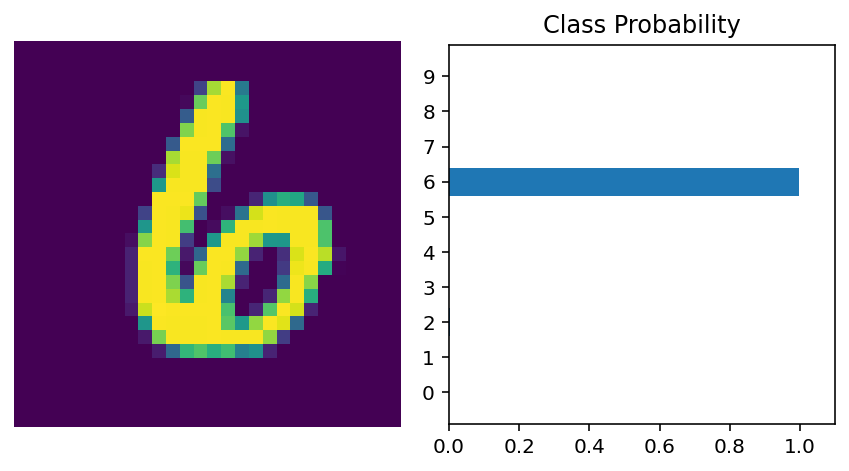

In [31]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    logps = model(img)

# As saidas da rede são o log da probabilidade, por isso precisamos fazer o exponencial para termos as 
#    probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

In [32]:
# Modelo com dropout -> regularização:

In [33]:
from torch import nn

class Network(nn.Module):
    def __init__(self, train=True):
        super(Network, self).__init__()
        
        # Entradas para transformação linear da camada escondida
        self.hidden = nn.Linear(784, 256)
        # Camada de saída, 10 unidades, 1 para cada dígito
        self.output = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.2) # (wx+b)*self.dropout
        self.train=train
        
        # Define a função Sigmoid e LogSoftmax
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)#nn.Softmax(dim=1)
        
    def forward(self, x):
        # Passa o tensor de entrada por cada uma das operações
        if self.train:
            x = self.dropout(self.hidden(x))
        else:
            x = self.hidden(x)
        x = self.sigmoid(x)        
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [34]:
# Definindo o modelo, o critério e o atualizador:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.44165752359481253
Training loss: 0.2242998403391795
Training loss: 0.17333185855053
Training loss: 0.14761463919285137
Training loss: 0.12527497226336617


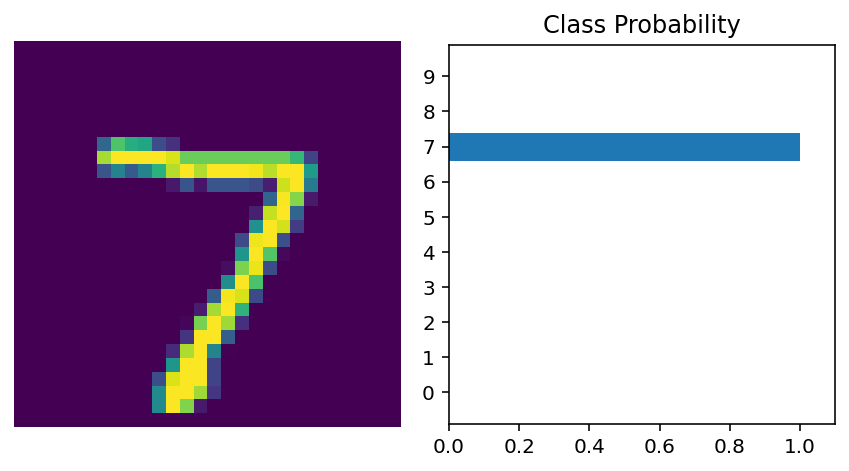

In [35]:
%matplotlib inline
import helper

images, labels = next(iter(testloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    model.train=False
    logps = model(img)

# As saidas da rede são o log da probabilidade, por isso precisamos fazer o exponencial para termos as 
#    probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)